# Stochastic Variational Inference with Gaussian Processes

### Written by Alan Saul, Dec 22 2014

In 2013 stocastic variational inference was implemented within the setting of Gaussian Processes [Gaussian Processes for Big Data, Hensman, Fusi and Lawrence, UAI 2013]. This allows us to perform inference on much larger datasets than was previously possible.

Here we will show a simple demonstration of this work implemented within the GPy framework.

First lets import some of the essentials, first we must note that within the model we rely on a optimization library called [climin](http://climin.readthedocs.org/en/latest/), so this must first be [installed](http://climin.readthedocs.org/en/latest/installation.html).

In [2]:
!pip install watermark

  Running setup.py bdist_wheel for watermark ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/33/f6/cb/7a2aead455228e622f63ebae218553c8b5f63438b2f3f1e4f4
Successfully built watermark


In [4]:
#load watermark
%load_ext watermark
%watermark -a 'Gopala KR' -u -d -v -p watermark,numpy,matplotlib,GPy

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Gopala KR 
last updated: 2018-03-05 

CPython 2.7.14
IPython 5.4.1

watermark 1.6.0
numpy 1.11.3
matplotlib 2.1.0
GPy 1.9.2


In [6]:
!pip install climin

  Running setup.py bdist_wheel for climin ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/80/d7/e9/92bffdc717097ea347afeb632dbf214ff594e9b7a74a416963
Successfully built climin


In [7]:
import numpy as np
import GPy
from matplotlib import pyplot as plt
import climin
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#plt.rcParams['figure.figsize'] = 8,8

First generate some data, in this example we will learn a multiple output model with the Stochastic Variational Inference model, where each output is independent given the input, and the noise is Gaussian. We will use a traditionally quite large number of data for a GP model (5000 datapoints) and learn stochastically looking at a batch of only 10 at a time.

In [8]:
N=5000
X = np.random.rand(N)[:, None]
Y1 = np.sin(6*X) + 0.1*np.random.randn(N,1)
Y2 = np.sin(3*X) + 0.1*np.random.randn(N,1)
Y = np.hstack((Y1, Y2))

Lets look at the data, since we have two outputs we will need to plot these seperately. You might notice a lag since we are plotting all the data.

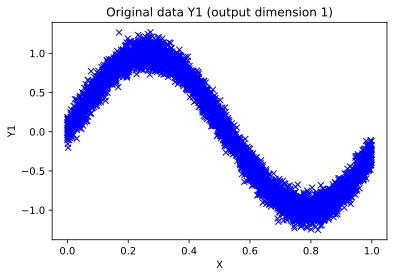

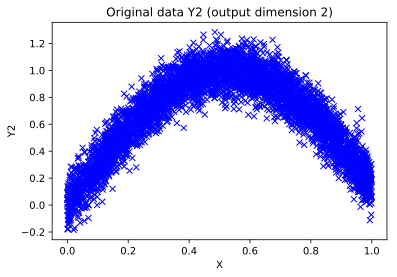

In [9]:
            X_variance = None
plt.figure()
plt.plot(X, Y1, 'bx', alpha=0.2)
plt.xlabel('X')
plt.ylabel('Y1')
_ = plt.title('Original data Y1 (output dimension 1)')

plt.figure()
plt.plot(X, Y2, 'bx', alpha=0.2)
plt.xlabel('X')
plt.ylabel('Y2')
_ = plt.title('Original data Y2 (output dimension 2)')

Now we will create a simple model. We will use only 10 data at a time during inference, this is done by setting the batchsize parameter. The model repeatedly choose a new (size 10) subset of the full data and use this to calculate a stochastic estimate of the full gradient. We choose to add a white variance kernel, this can stablise the covariance inversions that needs to be done, many people refer to this trick as fixed jitter, really it is just adding some additional variance to the diagonal of the covariance matrix, which helps keep it positive definite. 

In [10]:
Z = np.random.rand(20,1)

batchsize = 10
m = GPy.core.SVGP(X, Y, Z, GPy.kern.RBF(1) + GPy.kern.White(1), GPy.likelihoods.Gaussian(), batchsize=batchsize)
m.kern.white.variance = 1e-5
m.kern.white.fix()

 /home/nbuser/anaconda2_501/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
 /home/nbuser/anaconda2_501/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning:This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.


array([0])

Now we choose a optimizer, we choose here to use the climin project to allow us to use the Adadelta optimization routine. We have found Adadelta performs well in a stochastic setting but other optimisers can be used easily. Adadelta takes an initial set of parameters to start with (m.optimizer_array is an array which holds all of the parameters that can be optimised in the GPy model), and a function that given some new parameter settings, sets the model parameters and computes the gradients using these parameters against the data (m.stochastic_grad in this case).

m.stocastic_grad first chooses a new mini-batch from the whole dataset, sets the parameters of the SVI model to be those provided by Adadelta, and then computes the gradients of the log-likelihood of the mini-batch of data under the model, with respect to the newly set parameters.

The optimisation routine simply uses Adadelta to choose where to step using these gradients, sets the new parameters, and repeats. Some useful information from the optimisation are returned which can be useful for diagnostics. In practice in stochastic methods convergence criteron are not always easy to set, in practice we run for some number of iterations or stop it when we see that the likelihood isn't changing dramatically.

The important thing to note is that we are only looking at 10 datum at a time, and thus computing the gradients and updating the model is extremely quick, as we do not require a $O(5000^3)$ operation as is usual in vanilla GP models.

In [ ]:
opt = climin.Adadelta(m.optimizer_array, m.stochastic_grad, step_rate=0.2, momentum=0.9)
from ipywidgets import Text
from IPython.display import display

t = Text(align='right')
display(t)

import sys
def callback(i):
    t.value = str(m.log_likelihood())
    #Stop after 5000 iterations
    if i['n_iter'] > 5000:
        return True
    return False
info = opt.minimize_until(callback)

A Jupyter Widget

 /home/nbuser/anaconda2_501/lib/python2.7/site-packages/GPy/core/svgp.py:61: RuntimeWarning:overflow encountered in add


Now we can plot the two outputs of the model independently, where we also show (black crosses) the data from the last mini-batch used. Here we use which_data_ycols to choose the output to plot. We see a close match between the original data and the GP fit.

In [ ]:
fig1, axes = plt.subplots(1, 2, figsize=(10,5))
ax = axes[0]
ax.plot(X, Y1, 'kx', alpha=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y1')
ax.set_title('SVI Y1 prediction with data')
_ = m.plot(which_data_ycols=[0], plot_limits=(X.min(),X.max()), ax=ax)
ax.set_xlim((X.min(),X.max()))

ax = axes[1]
ax.plot(X, Y2, 'kx', alpha=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y2')
ax.set_title('SVI Y2 prediction with data')
_ = m.plot(which_data_ycols=[1], plot_limits=(X.min(),X.max()), ax=ax)
ax.set_xlim((X.min(),X.max()))

fig1.tight_layout()